In [56]:
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
from smplpytorch.pytorch.smpl_layer import SMPL_Layer
from display_utils import display_model
import pickle
import joblib
import os
import numpy as np
from scipy.interpolate import interp1d
from imu_base import calculate_patch_IMU_signals
import torch
from scipy.spatial.transform import Rotation as R
from imu_noise import add_imu_noise,sharpen_peaks
from inerpolate import upsample_smpl_with_jitter

In [57]:
pkl_file = '/home/lala/Downloads/wham_output 2.pkl'
smpl_data = joblib.load(pkl_file)
print(smpl_data[0].keys())
loaded_data = smpl_data[0]

dict_keys(['pose', 'trans', 'pose_world', 'trans_world', 'betas', 'verts', 'frame_ids'])


In [58]:
# ----------------------------------------------------
# 1) Load original motion data
# ----------------------------------------------------
poses = loaded_data['pose']   # (N, 72)
betas = loaded_data['betas']  # (N, 10)
trans = loaded_data['trans']  # (N, 3)



In [59]:
# ----------------------------------------------------
# 2) Interpolate to high frequency
# ----------------------------------------------------
fps_original = 15
fps_high = 15
dt = 1.0 / fps_high


num_frames = poses.shape[0]
duration = num_frames / fps_original

t_original = np.linspace(0, duration, num_frames)
num_frames_high = int(duration * fps_high)
t_high = np.linspace(0, duration, num_frames_high)

# Interpolate translation
trans_high = np.zeros((num_frames_high, 3))
for d in range(3):
    f = interp1d(t_original, trans[:, d], kind='cubic')
    trans_high[:, d] = f(t_high)

# Interpolate poses (component-wise for simplicity)
poses_high = np.zeros((num_frames_high, poses.shape[1]))
for d in range(poses.shape[1]):
    f = interp1d(t_original, poses[:, d], kind='cubic')
    poses_high[:, d] = f(t_high)


In [60]:
# ----------------------------------------------------
# 3) Setup SMPL layer
# ----------------------------------------------------
smpl_layer = SMPL_Layer(
    center_idx=0,
    gender='neutral',
    model_root='smplpytorch/native/models'
)

cuda = torch.cuda.is_available()
if cuda:
    smpl_layer.cuda()

In [61]:
print(f"Generating high-freq SMPL meshes: {num_frames_high} frames at {fps_high} Hz")

all_verts = []
all_jtr = []

for i in range(num_frames_high):
    pose_params = torch.tensor(poses_high[i:i+1], dtype=torch.float32)
    shape_params = torch.tensor(betas[0:1], dtype=torch.float32)

    if cuda:
        pose_params = pose_params.cuda()
        shape_params = shape_params.cuda()

    with torch.no_grad():
        verts, Jtr = smpl_layer(pose_params, th_betas=shape_params)

    #verts[:, :, 1] *= -1  # flip Y if needed
    #Jtr[:, :, 1] *= -1

    # SAFE translation addition
    trans_torch = torch.tensor(trans_high[i:i+1], dtype=torch.float32)
    if cuda:
        trans_torch = trans_torch.cuda()

    verts = verts + trans_torch
    jtr = Jtr + trans_torch

    all_verts.append(verts.cpu().numpy())
    all_jtr.append(jtr.cpu().numpy())

all_verts = np.array(all_verts) 
all_jtr = np.array(all_jtr)

print(f"Verts shape: {all_verts.shape}")
print(f"Verts shape: {all_jtr.shape}")


Generating high-freq SMPL meshes: 42 frames at 15 Hz
Verts shape: (42, 1, 6890, 3)
Verts shape: (42, 1, 24, 3)


In [62]:
# ----------------------------------------------------
# 5) IMU cluster list
# ----------------------------------------------------
UTD_lists = {
    'right_wrist': {
        #'verts': [5405, 5430, 5431]
        'verts': [5669, 5705, 5430]
    },
    'right_thigh': {
        'verts': [847, 849, 957]
    }
}

In [63]:
# ----------------------------------------------------
# 6) Make height 1.75
# ----------------------------------------------------

lists = {
    'forehead': [0, 1, 5, 132, 133, 232, 234, 235, 259, 335, 336, 3512, 3513, 3514, 3515, 3517, 3644, 3645, 3646, 3676, 3744, 3745, 3746, 3771],
    'right_leg': [847, 848, 849, 850, 872, 873, 874, 875, 876, 877, 904, 905, 906, 907, 957, 1159, 1365, 1366, 1499, 1500],
    'left_leg': [4333, 4334, 4335, 4336, 4358, 4359, 4360, 4361, 4362, 4363, 4645, 4648, 4711, 4712, 4801, 4802, 4839]
}

forehead_indices = lists['forehead']
right_leg_indices = lists['right_leg']
left_leg_indices = lists['left_leg']

forehead_centroids = np.mean(all_verts[:, 0, forehead_indices], axis=1)
right_leg_centroids = np.mean(all_verts[:, 0, right_leg_indices], axis=1)
left_leg_centroids = np.mean(all_verts[:, 0, left_leg_indices], axis=1)

# Calculate centroid of legs (average of right and left)
leg_centroids = (right_leg_centroids + left_leg_centroids) / 2

# Calculate Euclidean distance between forehead and leg centroids
distances = np.linalg.norm(forehead_centroids - leg_centroids, axis=1)
average_height = np.mean(distances)
scale_factor = 1.75 / average_height

all_verts = np.array(all_verts) * scale_factor
all_jtr = np.array(all_jtr) * scale_factor

In [64]:
from imu_base import calculate_patch_IMU_signals
# ----------------------------------------------------
# 7) Compute & save for each patch IMU
# ----------------------------------------------------
save_dir = "/home/lala/2"
os.makedirs(save_dir, exist_ok=True)

for body_part, config in UTD_lists.items():
    verts = config['verts']

    print(f"Processing PATCH IMU: {body_part}")

    positions, orientations, linear_accel_loc, linear_accel_world, angular_velo = calculate_patch_IMU_signals(
        all_verts,
        verts,
        dt
    )

    file_path = os.path.join(save_dir, f'{body_part}.npz')
    np.savez(file_path,
             positions=positions,
             orientations=orientations,
             global_acceleration=linear_accel_world,
             local_accel=linear_accel_loc,
             angular_velocity=angular_velo)

    print(f"Saved PATCH IMU data: {file_path}")


Processing PATCH IMU: right_wrist
Saved PATCH IMU data: /home/lala/2/right_wrist.npz
Processing PATCH IMU: right_thigh
Saved PATCH IMU data: /home/lala/2/right_thigh.npz


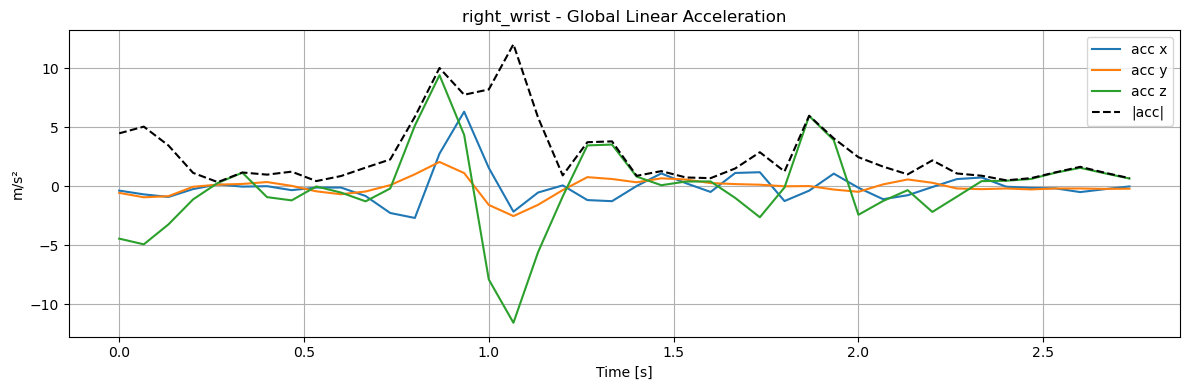

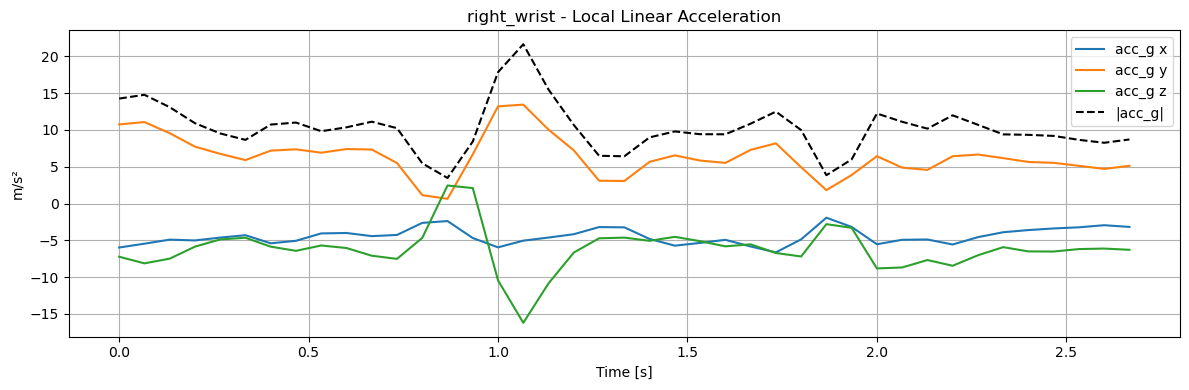

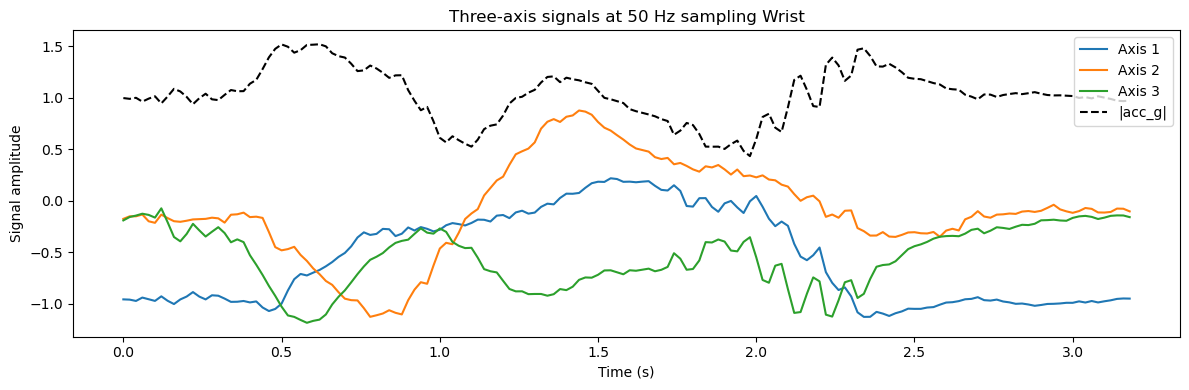

In [65]:
import os
import numpy as np
import matplotlib.pyplot as plt

# --- Config ---
save_dir = r"/home/lala/2"
body_part = 'right_wrist'

file_path = os.path.join(save_dir, f'{body_part}.npz')
data = np.load(file_path)

acc = data['global_acceleration']
acc_g = data['local_accel']
ang_vel = data['angular_velocity']

fps = fps_high

# Time for acc
t_acc = np.arange(len(acc)) / fps

# Time for acc_g
t_acc_g = np.arange(len(acc_g)) / fps

# Time for ang_vel
t_ang = np.arange(len(ang_vel)) / fps

# --- Plot global linear acceleration ---
plt.figure(figsize=(12, 4))
plt.title(f"{body_part} - Global Linear Acceleration")
for i, axis in enumerate(['x', 'y', 'z']):
    plt.plot(t_acc, acc[:, i], label=f'acc {axis}')
plt.plot(t_acc, np.linalg.norm(acc, axis=1), 'k--', label='|acc|')
plt.xlabel('Time [s]')
plt.ylabel('m/s²')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot local linear acceleration ---
plt.figure(figsize=(12, 4))
plt.title(f"{body_part} - Local Linear Acceleration")
for i, axis in enumerate(['x', 'y', 'z']):
    plt.plot(t_acc_g, acc_g[:, i], label=f'acc_g {axis}')
plt.plot(t_acc_g, np.linalg.norm(acc_g, axis=1), 'k--', label='|acc_g|')
plt.xlabel('Time [s]')
plt.ylabel('m/s²')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


import pandas as pd
import scipy.io
 
 
real_inertial_data = scipy.io.loadmat("/home/lala/Downloads/a1_s1_t1_inertial.mat")['d_iner']
 

fs = 50          # sampling frequency in Hz
dt = 1.0 / fs    # time between samples
N = real_inertial_data.shape[0]
 
# build the time vector
t = np.arange(N) * dt
 
plt.figure(figsize=(12, 4))
plt.plot(t, real_inertial_data[:, 0], label='Axis 1')
plt.plot(t, real_inertial_data[:, 1], label='Axis 2')
plt.plot(t, real_inertial_data[:, 2], label='Axis 3')
plt.plot(t, np.linalg.norm(real_inertial_data[:,0:3], axis=1), 'k--', label='|acc_g|')
 
plt.xlabel('Time (s)')
plt.ylabel('Signal amplitude')
plt.title('Three-axis signals at 50 Hz sampling Wrist')
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
angular_velocity_sharp = sharpen_peaks(ang_vel,power_range=(1.1, 1.5),mix=0.8)
acc_sharp = sharpen_peaks(acc_g, power_range=(1.01, 1.05), mix=0.4)

acc_realistic = add_imu_noise(acc_sharp, fs=fps_high, noise_type='full')
gyro_realistic = add_imu_noise(angular_velocity_sharp, fs=fps_high, noise_type='full')

# --- Plot local linear acceleration ---
plt.figure(figsize=(12, 4))
plt.title(f"{body_part} - Local Linear Acceleration")
for i, axis in enumerate(['x', 'y', 'z']):
    plt.plot(t_acc_g, acc_realistic[:, i], label=f'acc_g {axis}')
plt.plot(t_acc_g, np.linalg.norm(acc_realistic, axis=1), 'k--', label='|acc_g|')
plt.xlabel('Time [s]')
plt.ylabel('m/s²')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot angular velocity ---
plt.figure(figsize=(12, 4))
plt.title(f"{body_part} - Angular Velocity")
for i, axis in enumerate(['x', 'y', 'z']):
    plt.plot(t_ang, gyro_realistic[:, i], label=f'ω {axis}')
plt.plot(t_ang, np.linalg.norm(gyro_realistic, axis=1), 'k--', label='|ω|')
plt.xlabel('Time [s]')
plt.ylabel('rad/s')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ValueError: Digital filter critical frequencies must be 0 < Wn < 1

In [23]:
new_jtr = np.squeeze(all_jtr, axis=1)


(42, 24, 3)
(41, 3)


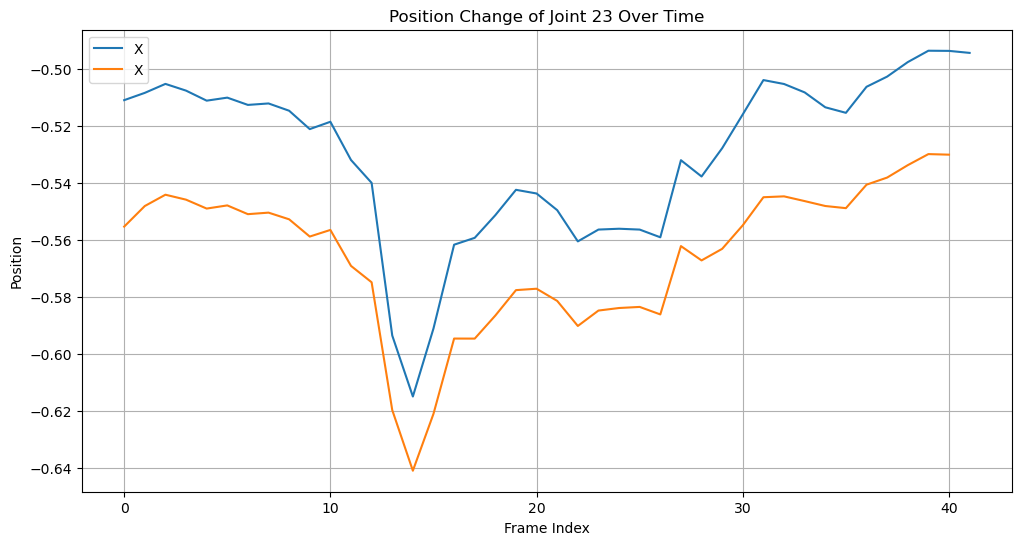

In [24]:
print(new_jtr.shape)
# Select joint number 23 (index 23 in zero-based indexing)
joint_index = 23
joint_23_positions = new_jtr[:, joint_index, :]  # shape: [280, 3]
pose = data['positions']
print(pose.shape)


# Plot X, Y, Z over time
plt.figure(figsize=(12, 6))
plt.plot(joint_23_positions[:, 0], label='X')
#plt.plot(joint_23_positions[:, 1], label='Y')
#plt.plot(joint_23_positions[:, 2], label='Z')
plt.plot(pose[:, 0], label='X')
#plt.plot(pose[:, 1], label='Y')
#plt.plot(pose[:, 2], label='Z')

plt.title('Position Change of Joint 23 Over Time')
plt.xlabel('Frame Index')
plt.ylabel('Position')
plt.legend()
plt.grid(True)
plt.show()


(41, 4)
Euler shape: (41, 3)


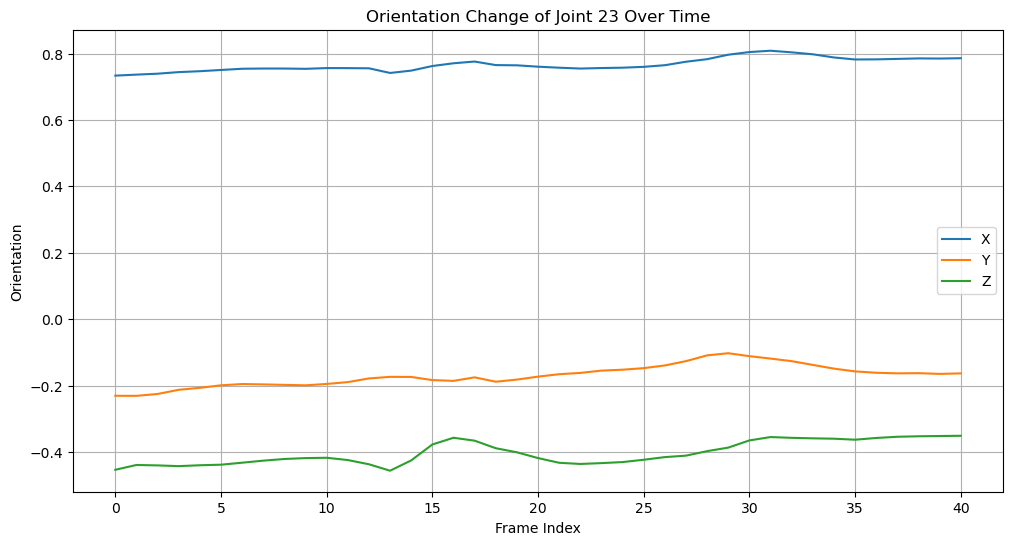

In [25]:
ore = data['orientations']
print(ore.shape)

from scipy.spatial.transform import Rotation as R

def quaternion_to_euler(quat, order='xyz', degrees=False):
    """
    Convert quaternion(s) to Euler angles.

    quat: array-like, shape (..., 4)
    order: Euler sequence (e.g., 'xyz')
    degrees: True for degrees, False for radians
    """
    quat = np.atleast_2d(quat)
    r = R.from_quat(quat)
    euler = r.as_euler(order, degrees=degrees)
    return euler

# Normalize quaternions for safety
#ore /= np.linalg.norm(ore, axis=1, keepdims=True)

# Convert to Euler angles
eulers = quaternion_to_euler(ore, order='xyz', degrees=True)

print("Euler shape:", eulers.shape)  # (41, 3)

# Plot X, Y, Z over time
plt.figure(figsize=(12, 6))
plt.plot(ore[:, 1], label='X')
plt.plot(ore[:, 2], label='Y')
plt.plot(ore[:, 3], label='Z')

plt.title('Orientation Change of Joint 23 Over Time')
plt.xlabel('Frame Index')
plt.ylabel('Orientation')
plt.legend()
plt.grid(True)
plt.show()


Euler shape: (42, 3)


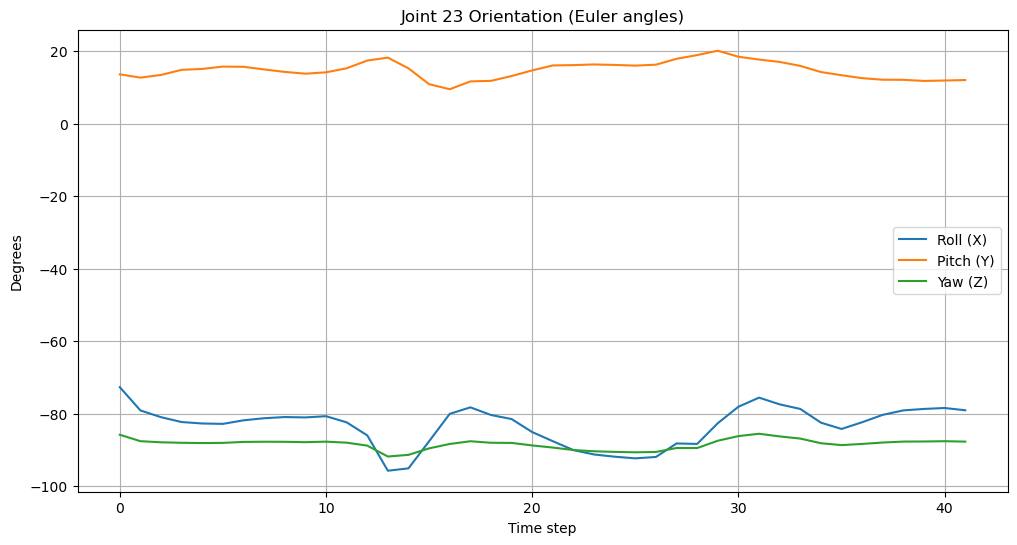

In [26]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

# Example: your joint data (42, 1, 24, 3)
jtr = all_jtr.squeeze(axis=1)  # (42, 24, 3)

num_frames = jtr.shape[0]

frames_R = []

for t in range(num_frames):
    # Positions
    j21 = jtr[t, 21, :]  # parent
    j23 = jtr[t, 23, :]  # child

    # X-axis: bone vector (21 -> 23)
    X = j23 - j21
    X /= np.linalg.norm(X)

    # To define a full frame, we need more than one vector.
    # So pick a consistent UP vector (e.g., global Y) to define Z.
    # Then Y = Z × X.

    # If X is parallel to UP, choose another fallback.
    UP = np.array([0, 1, 0])
    if np.abs(np.dot(X, UP)) > 0.99:
        UP = np.array([0, 0, 1])

    Z = np.cross(X, UP)
    Z /= np.linalg.norm(Z)

    Y = np.cross(Z, X)

    # Assemble rotation matrix: columns are the axes
    R_frame = np.stack([X, Y, Z], axis=1)  # (3, 3)
    frames_R.append(R_frame)

frames_R = np.stack(frames_R)  # (42, 3, 3)

# Convert to quaternions
joint23_quat = R.from_matrix(frames_R).as_quat()  # (42, 4)

# Convert to Euler angles for plotting
joint23_euler = R.from_quat(joint23_quat).as_euler('xyz', degrees=True)

print("Euler shape:", joint23_euler.shape)

# Plot Euler angles
plt.figure(figsize=(12, 6))
plt.plot(joint23_euler[:, 0], label='Roll (X)')
plt.plot(joint23_euler[:, 1], label='Pitch (Y)')
plt.plot(joint23_euler[:, 2], label='Yaw (Z)')
plt.title('Joint 23 Orientation (Euler angles)')
plt.xlabel('Time step')
plt.ylabel('Degrees')
plt.legend()
plt.grid(True)
plt.show()


Angle shape: (160, 3)


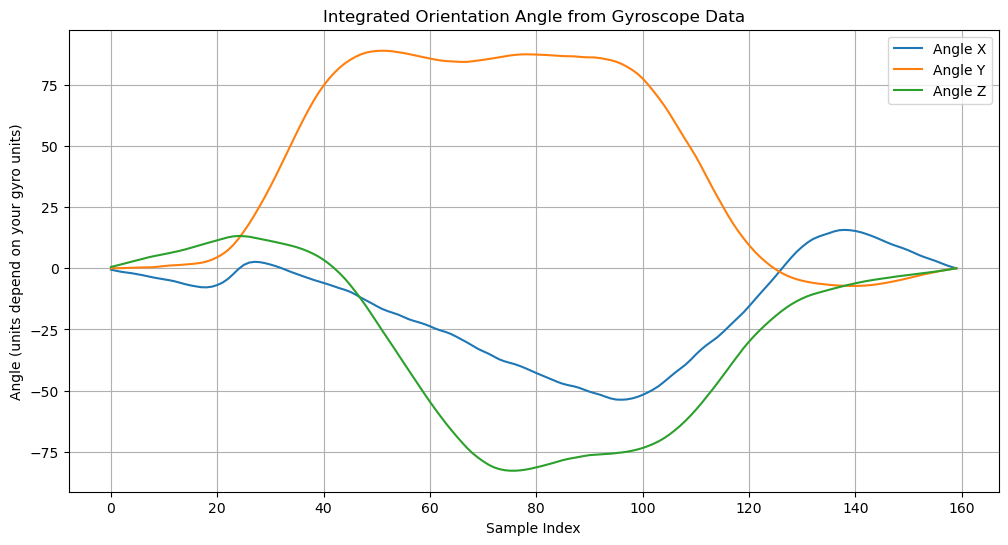

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Sampling frequency and dt
fs = 50  # Hz
dt = 1.0 / fs
N = real_inertial_data.shape[0]

# Extract gyro data (angular velocity)
gyro_data = real_inertial_data[:, 3:6]  # shape (N, 3)

# OPTIONAL: Remove mean bias to reduce drift
gyro_data_detrended = gyro_data - np.mean(gyro_data, axis=0)

# Integrate: angle = ∫ (angular velocity) dt
angle = np.cumsum(gyro_data_detrended, axis=0) * dt

print("Angle shape:", angle.shape)  # should be (N, 3)

# Plot integrated angles
plt.figure(figsize=(12, 6))
plt.plot(angle[:, 0], label='Angle X')
plt.plot(angle[:, 1], label='Angle Y')
plt.plot(angle[:, 2], label='Angle Z')
plt.title('Integrated Orientation Angle from Gyroscope Data')
plt.xlabel('Sample Index')
plt.ylabel('Angle (units depend on your gyro units)')
plt.legend()
plt.grid(True)
plt.show()

(42, 24, 3)
(42, 3)


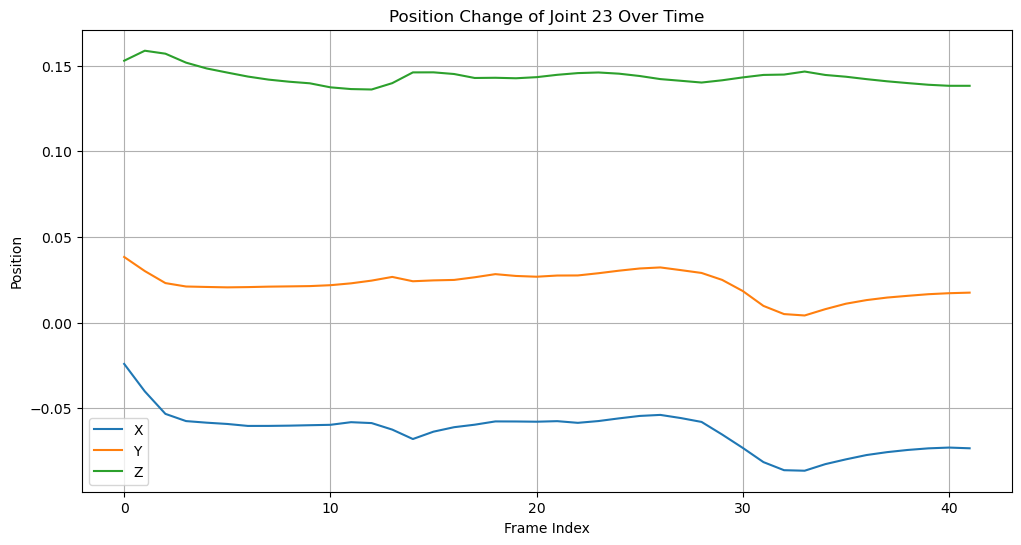

In [28]:
poses = loaded_data['pose'].reshape(42,24,3)
print(poses.shape)

joint_index = 23
joint_23_positions = poses[:, joint_index, :]  # shape: [280, 3]
print(joint_23_positions.shape)


# Plot X, Y, Z over time
plt.figure(figsize=(12, 6))
plt.plot(joint_23_positions[:, 0], label='X')
plt.plot(joint_23_positions[:, 1], label='Y')
plt.plot(joint_23_positions[:, 2], label='Z')


plt.title('Position Change of Joint 23 Over Time')
plt.xlabel('Frame Index')
plt.ylabel('Position')
plt.legend()
plt.grid(True)
plt.show()


Original quaternion shape: (41, 4)
Relative Euler shape: (41, 3)


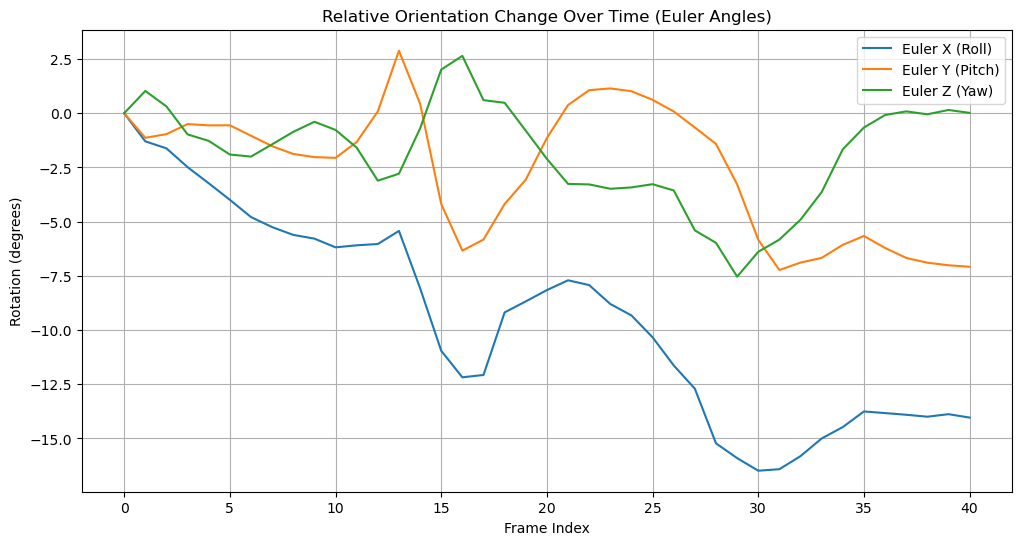

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

ore = data['orientations']
print("Original quaternion shape:", ore.shape)  # (N, 4)

# Ensure quaternions are normalized
ore /= np.linalg.norm(ore, axis=1, keepdims=True)

# Convert to Rotation objects
rot = R.from_quat(ore)

# Get the inverse of the first rotation (the starting orientation)
rot0_inv = rot[0].inv()

# Compute relative rotations: q_rel = q0_inv * q_t
rot_rel = rot0_inv * rot  # uses Rotation's __mul__

# Convert relative rotations to Euler angles
eulers_rel = rot_rel.as_euler('xyz', degrees=True)

print("Relative Euler shape:", eulers_rel.shape)

# Plot the relative Euler angles
plt.figure(figsize=(12, 6))
plt.plot(eulers_rel[:, 0], label='Euler X (Roll)')
plt.plot(eulers_rel[:, 1], label='Euler Y (Pitch)')
plt.plot(eulers_rel[:, 2], label='Euler Z (Yaw)')

plt.title('Relative Orientation Change Over Time (Euler Angles)')
plt.xlabel('Frame Index')
plt.ylabel('Rotation (degrees)')
plt.legend()
plt.grid(True)
plt.show()
